In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
data = pd.read_csv("C:/Users/MehmetSalih/Desktop/creditcard.csv")

df = data.copy()

In [9]:

scaler = RobustScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))


df.drop(['Time', 'Amount'], axis=1, inplace=True)


X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu: {X_test.shape}")

Eğitim Seti Boyutu: (227845, 30)
Test Seti Boyutu: (56962, 30)


In [10]:
neg, pos = np.bincount(df['Class'])
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"\nModel için Sınıf Ağırlıkları -> Normal: {weight_for_0:.2f}, Fraud: {weight_for_1:.2f}")


Model için Sınıf Ağırlıkları -> Normal: 0.50, Fraud: 289.44


In [11]:
METRICS = [
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

model = keras.Sequential([
    
    keras.Input(shape=(X_train.shape[-1],)),
    
    
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)


In [12]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

print("\nModel eğitimi başlıyor...")
history = model.fit(
    X_train, y_train,
    batch_size=2048, # Büyük veri seti olduğu için büyük batch size
    epochs=100,      # Maksimum 100 epoch
    callbacks=[early_stopping],
    validation_data=(X_test, y_test),
    class_weight=class_weight, # Kritik nokta: Dengesizliği çözen parametre
    verbose=1
)


Model eğitimi başlıyor...
Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - auc: 0.6866 - fn: 112.0000 - fp: 102179.0000 - loss: 0.7409 - precision: 0.0028 - recall: 0.7157 - tn: 125272.0000 - tp: 282.0000 - val_auc: 0.9343 - val_fn: 11.0000 - val_fp: 12770.0000 - val_loss: 0.5546 - val_precision: 0.0068 - val_recall: 0.8878 - val_tn: 44094.0000 - val_tp: 87.0000
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.7938 - fn: 130.0000 - fp: 57896.0000 - loss: 0.5791 - precision: 0.0045 - recall: 0.6701 - tn: 169555.0000 - tp: 264.0000 - val_auc: 0.9651 - val_fn: 11.0000 - val_fp: 4502.0000 - val_loss: 0.4035 - val_precision: 0.0190 - val_recall: 0.8878 - val_tn: 52362.0000 - val_tp: 87.0000
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8748 - fn: 99.0000 - fp: 41137.0000 - loss: 0.4737 - precision: 0.0071 - recall: 0.7487 - tn: 186314.0000 - tp: 295.0000 - val_auc: 0.9705 - val_fn: 11.0000 - val_fp: 1895.0000 - val_loss: 0.2937 - val_precision: 0.0439 - v

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step

--- DETAYLI SINIFLANDIRMA RAPORU ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962



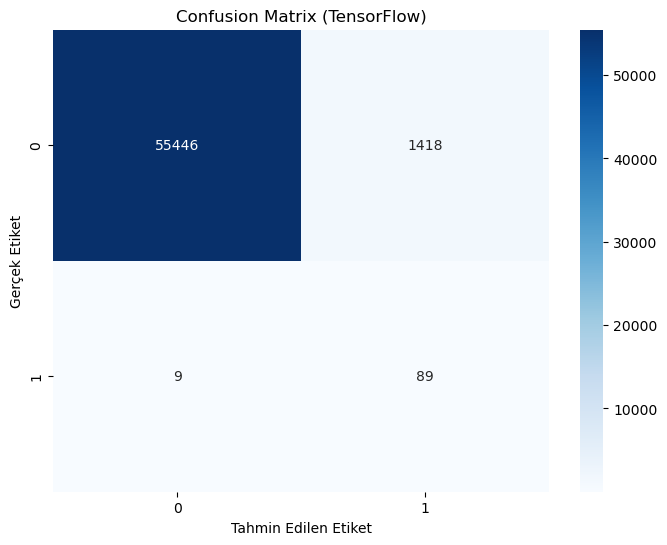

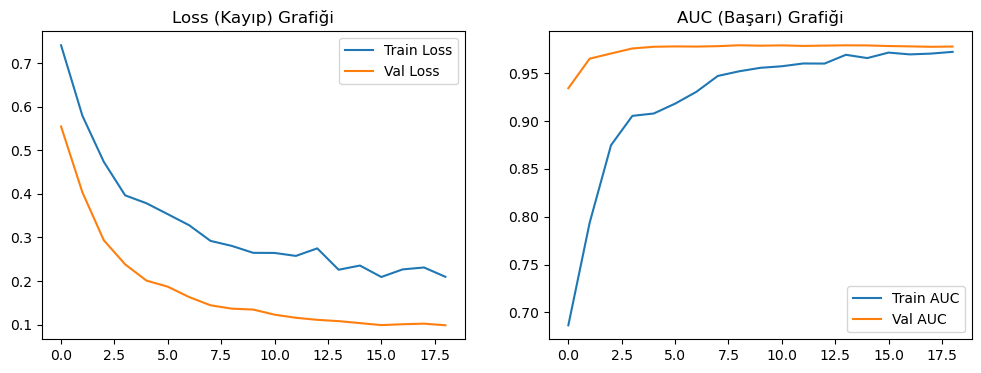

In [13]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (TensorFlow)')
    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmin Edilen Etiket')
    plt.show()

# Test seti üzerinde tahmin yap
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int) # %50 eşik değeri ile sınıfları belirle

print("\n--- DETAYLI SINIFLANDIRMA RAPORU ---")
print(classification_report(y_test, y_pred))

# Grafikleri Çiz
plot_confusion_matrix(y_test, y_pred)

# Eğitim Süreci (Loss ve AUC)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (Kayıp) Grafiği')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC (Başarı) Grafiği')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

# 1. Tahminleri Netleştirelim (0 veya 1 olarak)
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# 2. Confusion Matrix'ten Değerleri Çıkaralım
# .ravel() fonksiyonu matrisi düzleştirip 4 değişkene dağıtır
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# 3. Sonuçları Bastıralım
print("--- Garanti Yöntem (Sklearn) ---")
print(f"True Negatives  (TN - Doğru Normal) : {tn}")
print(f"False Positives (FP - Yanlış Alarm) : {fp}")
print(f"False Negatives (FN - Kaçan Fraud)  : {fn}")
print(f"True Positives  (TP - Yakalanan)    : {tp}")

# Başarı Oranını Hesapla
print(f"\nModelin Yakalama Oranı (Recall): %{(tp / (tp + fn)) * 100:.2f}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step
--- Garanti Yöntem (Sklearn) ---
True Negatives  (TN - Doğru Normal) : 55446
False Positives (FP - Yanlış Alarm) : 1418
False Negatives (FN - Kaçan Fraud)  : 9
True Positives  (TP - Yakalanan)    : 89

Modelin Yakalama Oranı (Recall): %90.82
